# Project 2: Digit Classification Naive Bayes

**Solution**

# Intro
---
In this project, you'll continue working on your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. 
As always, you're welcome to work on the project in groups and discuss ideas over Slack, but <b> please prepare your own write-up (with your own code). </b>


## Grading
---
 - Make sure to answer every part in every question.
 - There are 6 questions, each equally weighted and an additional bonus question.
 - The extra credit question will be graded based on your attempts at feature engineering and resulting improved accuracy.
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean, well commented,
  -  if the functions or answers are too long.

## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).

## Additional Reading and notes
---
If you're interested, check out these links related to digit recognition:

* Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
* Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

Finally, if you'd like to get started with Tensorflow, you can read through this tutorial: https://www.tensorflow.org/tutorials/keras/basic_classification. It uses a dataset called "fashion_mnist", which is identical in structure to the original digit mnist, but uses images of clothing rather than images of digits. The number of training examples and number of labels is the same. In fact, you can simply replace the code that loads "fashion_mnist" with "mnist" and everything should work fine.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [5]:
import sklearn
sklearn.__version__

'0.24.1'

Load the data. Notice that the data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which you should use in all the experiments below, unless otherwise noted.

In [4]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False, as_frame = False)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


In [20]:
mini_train_labels

array(['0', '5', '7', '3', '6', '0', '8', '4', '9', '3', '2', '1', '8',
       '6', '1', '8', '7', '7', '0', '8', '5', '9', '6', '8', '6', '3',
       '1', '9', '2', '2', '8', '2', '6', '2', '6', '5', '7', '2', '8',
       '2', '6', '3', '6', '5', '1', '8', '1', '4', '2', '1', '8', '5',
       '4', '8', '1', '7', '4', '1', '0', '4', '3', '4', '3', '6', '2',
       '9', '9', '9', '6', '3', '7', '8', '3', '4', '7', '8', '9', '1',
       '2', '7', '1', '6', '9', '8', '3', '9', '3', '8', '1', '0', '9',
       '6', '1', '1', '6', '4', '6', '7', '4', '7', '5', '5', '8', '0',
       '0', '9', '9', '8', '9', '2', '9', '2', '1', '9', '8', '7', '3',
       '5', '3', '9', '8', '9', '9', '6', '2', '8', '0', '3', '0', '5',
       '0', '7', '6', '1', '1', '3', '1', '4', '3', '5', '8', '2', '1',
       '6', '4', '1', '8', '6', '3', '7', '2', '1', '7', '8', '0', '4',
       '4', '1', '0', '0', '1', '0', '0', '4', '5', '4', '4', '3', '2',
       '9', '8', '1', '3', '0', '2', '8', '5', '5', '0', '7', '0

### Question 1: Applying a smoothing using numpy.
---

A common image processing technique is to smooth an image by **blurring**. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian, i.e., the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

1. Implement a simplified Gaussian blur filter by just using the 8 neighboring pixels like this: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values.
1. Choose some weights as a starting point. Produce and evaluate four 1-Nearest Neighbor models by applying your blur filter in these ways:
  1. Do not use the filter
  1. Filter the training data but not the dev data
  1. Filter the dev data but not the training data
  1. Filter both training data and dev data
1. Show the accuracies of the four models evaluated as described. What do you see? Can you explain why this is?
1. Experiment with weights that makes one model's accuracy at least 0.9.

Notes:
* Train on the (filtered) mini train set.
* Evaluate performance on the (filtered) dev set.
* A good trick to simplify your code is to use numpy's pad function to add 0s around your original array so you don't have to deal with "edge cases".
* In addition, you can use numpy to multiply and sum slices of two arrays.
* [This notebook](https://colab.research.google.com/drive/1eJXTQLtREXQjQIsLOA9uCrBl6B049-pO) might help shows some example numpy code.
* In general, [numpy operations will be much faster than for loops](https://colab.research.google.com/drive/1KJI4JtuIqVdyZHTTe_mAlKYA5XdLFp3_). 
* There are other Guassian blur filters available, for example in `scipy.ndimage.filters`. You are welcome to experiment with those, but in this question, please implement your own.

In [63]:
def Q1():
    
    ### STUDENT START ###
    
    def gaussian(df = 1):
        """produce and print weighted array filter matrix,
        where df is distance factor"""
        filter_array = np.array([[1, 2*df, 1], 
                                 [2*df, (2*df)**3, 2*df], 
                                 [1, 2*df, 1]])
        weighted_filter = filter_array / filter_array.sum()
        return weighted_filter

    def weighted_gaussian(filter_arr, weight = 1):
        """filter the filter array with weighted Gaussian matrix"""
        blurred_arr = np.zeros(shape = (len(filter_arr), 28*28))
        for x in range(len(filter_arr)):
            array_pad = np.pad(filter_arr[x].reshape(28, 28), (1, 1),
                              'constant', constant_values=(0,0))
            fltr_mini_train = np.ones((29, 29))
            for y in range(27):
                for z in range(27):
                    fltr_mini_train[y+1, z+1] = (array_pad[y:y+3, z:z+3]*gaussian(weight)).sum()
            blurred_arr[x] = fltr_mini_train[1:29, 1:29].reshape(1, 28*28)
        return blurred_arr

    def knn_accuracy(train_x, train_y, dev_x, dev_y):
        """..."""
        y_prediction = KNeighborsClassifier(n_neighbors=1).fit(train_x, train_y).predict(dev_x)
        return classification_report(dev_y, y_prediction, output_dict=True)['accuracy']
    
    weight = 1
    train_blur = weighted_gaussian(mini_train_data, weight)
    dev_blur = weighted_gaussian(dev_data, weight)
    
    # accuracy of KNN model prediction with no blur 
    no_blur = knn_accuracy(mini_train_data, mini_train_labels, dev_data, dev_labels)
    print("KNN model no blur accuracy: " + str(no_blur))
    
    # accuracy of KNN model prediction with training data blurred
    train_blur = knn_accuracy(train_blur, mini_train_labels, dev_data, dev_labels)
    print("KNN model with training data blurred (weight = 1) accuracy: " + str(train_blur))
    
    # accuracy of KNN model prediction with development data blurred
    dev_blur = knn_accuracy(mini_train_data, mini_train_labels, dev_blur, dev_labels)
    print("KNN model with development data blurred (weight = 1) accuracy: " + str(dev_blur))
    
    # accuracy of KNN model prediction with training and development data blurred
    #train_dev_blur = knn_accuracy(train_blur, mini_train_labels, dev_blur, dev_labels)
    #print("KNN model with training and development blurred (weight = 1) accuracy: " + str(train_dev_blur))
    
    
    # experimenting with different weights
    accuracies = []
    diff_weights = [1, 2, 3, 4, 5, 10]
    
    for i in diff_weights:
        # get prediction
        y_prediction = KNeighborsClassifier(n_neighbors = 1).fit(weighted_gaussian(mini_train_data, i), mini_train_labels).predict(dev_data)
        # get accuracies and append to list
        accuracies.append(classification_report(dev_labels, y_prediction, output_dict = True)['accuracy'])
    
    # make table of weights and accuracies
    df = pd.DataFrame({'Weight': pd.Series(diff_weights), 'Accuracy': pd.Series(accuracies)})
    print(df)
        
    
    ### STUDENT END ###

Q1()

KNN model no blur accuracy: 0.877
KNN model with training data blurred (weight = 1) accuracy: 0.895
KNN model with development data blurred (weight = 1) accuracy: 0.879
   Weight  Accuracy
0       1     0.895
1       2     0.882
2       3     0.884
3       4     0.882
4       5     0.880
5      10     0.877


### Question 2: Modeling your data and experimenting with different Naive Bayes models. 
---

1. Produce two Naive Bayes models and evaluate their performances.  Recall that Naive Bayes estimates P(feature|label), where each label is a categorical, not a real number.
  1. For the first model, map pixel values to either 0 or 1, representing white or black - you should pre-process the data or use `BernoulliNB`'s `binarize` parameter to set the white/black separation threshold to 0.1.  Use `BernoulliNB` to produce the model.
  1. For the second model, map pixel values to either 0, 1, or 2, representing white, gray, or black - you should pre-process the data, seting the white/gray/black separation thresholds to 0.1 and 0.9.  Here you'll likely need to implement a `trianarize` helper function. Since we are going beyond the binary representation of our features, you should use `MultinomialNB` to produce the model.
1. Show the Bernoulli model accuracy and the Multinomial model accuracy.
1. Does the multinomial version improve the results? Why or why not?

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.



In [30]:
# Solution with binarization by explicit binarize function

def Q2():
    ### STUDENT START ###
    """producing two Naive Bayes models + evaluating their performances""" 
    
    # Bernoulli: mapping pixel values to either 0 or 1 (white, black)
    mapped_data_b = np.empty(mini_train_data.shape)
    # digitizing to 0 or 1
    for i in range(mini_train_data.shape[1]):
        mapped_data_b[:,i] = np.digitize(mini_train_data[:,i], [0.1])
    # predicting via Bernoulli Naive Bayes
    b = BernoulliNB(alpha=1)
    b.fit(mapped_data_b, mini_train_labels)
    y_pred_b = b.predict(dev_data)
    # accuracy
    acc_b = classification_report(dev_labels, y_pred_b, output_dict = True)['accuracy']
    print("Bernoulli Naive Bayes model accuracy: " + str(acc_b))
    
    # Multinomial: mapping pixel values to either 0, 1, or 2 (white, gray, black)
    mapped_data_m = np.empty(mini_train_data.shape)
    # digitizing to 0, 1 or 2
    for i in range(mini_train_data.shape[1]):
        mapped_data_m[:,i] = np.digitize(mini_train_data[:,i], [0.1, 0.9])
    # predicting via Multinomial Naive Bayes
    m = MultinomialNB(alpha = 1)
    y_pred_m = m.fit(mapped_data_m, mini_train_labels).predict(dev_data)
    # accuracy
    acc_m = classification_report(dev_labels, y_pred_m, output_dict = True)['accuracy']
    print("Multinomial Naive Bayes model accuracy: " + str(acc_m))
    
    
    ### STUDENT END ###

Q2()

Bernoulli Naive Bayes model accuracy: 0.805
Multinomial Naive Bayes model accuracy: 0.795


ANSWER: Multinomial Naive Bayes model doesn't improve the results. This may be because the pixel distribution in our data is not uniform or evenly spread. If the pixel distribution clusters around two main values, then the Bernoulli Naive Bayes model will do slightly better, because the extra factor/feature in the Multinomial model is not necessary. 

### Question 3: Applying the grid search technique.
1. Search across several values of the LaPlace smoothing parameter (alpha) to find its effect on a Bernoulli Naive Bayes model's performance.  Show the accuracy at each alpha value.
1. What is the best value for alpha? What is the accuracy when alpha is near 0? Is this what you'd expect?

Notes:
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate performance by 5-fold cross-validation. 
* Use `GridSearchCV(..., ..., cv=..., scoring='accuracy', iid=False)` to vary alpha and evaluate performance by cross-validation.
* Cross-validation is based on partitions of the training data, so results will be a bit different than if you had used the dev set to evaluate performance.



In [36]:
def Q3(alphas):
    ### STUDENT START ###
    
    mapped_data_b = np.empty(mini_train_data.shape)
    
    for i in range(mini_train_data.shape[1]):
        mapped_data_b[:,i] = np.digitize(mini_train_data[:,i], [0.1])
    
    # grid search
    gs = GridSearchCV(BernoulliNB(binarize = None), param_grid=alphas)
    gs.fit(mapped_data_b, mini_train_labels)
    # print data frame of alphas and resulting accuracies (mean_scores)
    mean_scores = gs.cv_results_['mean_test_score']
    df = pd.DataFrame({'alpha': pd.Series(alphas['alpha']).astype(str), 'accuracy': pd.Series(mean_scores)})
    print(df)
    
    
    ### STUDENT END ###

alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
Q3(alphas)


    alpha  accuracy
0   1e-10     0.815
1  0.0001     0.830
2   0.001     0.834
3    0.01     0.833
4     0.1     0.830
5     0.5     0.828
6     1.0     0.827
7     2.0     0.820
8    10.0     0.782


ANSWER: The best value for alpha is 0.001, which gives an accuracy of 0.834. The accuracy near 0 is 0.815, which makes sense because an alpha of 0 means that we have a non smoothed estimator, which defeats the purpose of Laplace smoothing. 

### Question 4: Experimenting with Gaussian Naive Bayes
---
1. Produce a model using Guassian Naive Bayes, which is intended for real-valued features, and evaluate performance. You will notice that it does not work so well. 
1. Diagnose and explain the problem.
1. Apply a simple fix so that the model accuracy is around the same as for a Bernoulli Naive Bayes model. 
1. Show the model accuracy before your fix and the model accuracy after your fix.  
1. Explain your solution.

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* Take a look at var_smoothing argument for GaussianNB.
* Feel free to  examine theta and sigma to better understand what's happening. In general though, **it is not a good idea to mess with internal variables of the model**. These are stored in the model's `theta_` and `sigma_` attributes.

In [50]:
def Q4():
    ### STUDENT END ###
    
    # Gaussian Naive Bayes model
    g = GaussianNB().fit(mini_train_data, mini_train_labels)
    y_pred_g = g.predict(dev_data)
    acc_g = classification_report(dev_labels, y_pred_g, output_dict = True)['accuracy']
    print("Gaussian Naive Bayes model accuracy: " + str(acc_g))
    
    print("\n Changing variance smoothing values: ")
    
    # see accuracy of model with different variance smoothing values
    # from 0 to 1, increments of 0.01
    values = np.linspace(1e-9, 1, 21)
    diff_acc = []
    for i in values:
        diff_g = GaussianNB(var_smoothing = i).fit(mini_train_data, mini_train_labels)
        y_pred_diff_g = diff_g.predict(dev_data)
        acc_diff_g = classification_report(dev_labels, y_pred_diff_g, output_dict = True)['accuracy']
        diff_acc.append(acc_diff_g)
    # build data frame
    df = pd.DataFrame({'variance smoothing values': pd.Series(values), 
                      'accuracies': pd.Series(diff_acc)})
    print(df)
        
    
    
    ### STUDENT END ###

Q4()

Gaussian Naive Bayes model accuracy: 0.543

 Changing variance smoothing values: 
    variance smoothing values  accuracies
0                1.000000e-09       0.543
1                5.000000e-02       0.779
2                1.000000e-01       0.784
3                1.500000e-01       0.786
4                2.000000e-01       0.778
5                2.500000e-01       0.781
6                3.000000e-01       0.776
7                3.500000e-01       0.778
8                4.000000e-01       0.773
9                4.500000e-01       0.768
10               5.000000e-01       0.761
11               5.500000e-01       0.759
12               6.000000e-01       0.754
13               6.500000e-01       0.753
14               7.000000e-01       0.751
15               7.500000e-01       0.751
16               8.000000e-01       0.749
17               8.500000e-01       0.746
18               9.000000e-01       0.739
19               9.500000e-01       0.738
20               1.000000e+00       

ANSWER: The Gaussian Naive Bayes model has a default variance smoothing parameter of 1e-9, which results in an accuracy of 0.543. Because the Gaussian Naive Bayes assumes that each feature has an underlying Gaussian/normal distribution, the model performs poorly on our data because (as seen in question 2) seems to have a skewed distribution. Therefore, a variance smoothing parameter is needed to put more weight onto variables that are further away from the mean. 

### Question 5: Naive Bayes as a generative model
---
Because Naive Bayes produces a generative model, you can use it to generate digit images.

1. Produce a Bernoulli Naive Bayes model and then use it to generate a 10x10 grid with 10 example images of each digit. Each pixel output will be either 0 or 1: randomly generating a number and then comparing it to the estimated probability of the pixel being either 0 or 1.  Show the grid.
1. How do the generated digit images compare to the training digit images?

Notes:
* You can use np.random.rand() to generate random numbers from a uniform distribution.
* The estimated probability of each pixel being 0 or 1 is stored in the model's `feature_log_prob_` attribute. You can use `np.exp()` to convert a log probability back to a probability.



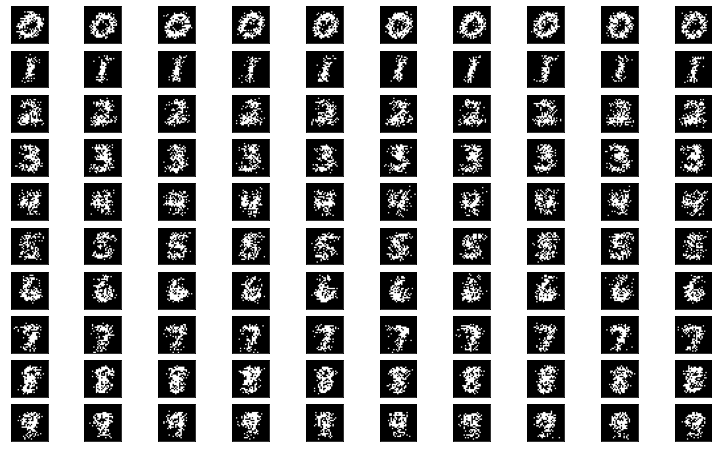

In [55]:
def Q5(num_examples):
    ### STUDENT START ###
    
    data = []
    # map binary data
    mapped_binary_data = np.empty(mini_train_data.shape)
    for i in range(mini_train_data.shape[1]):
        mapped_binary_data[:,i] = np.digitize(mini_train_data[:,i], [0.1])
    
    # Bernoulli NB model with alpha = 0.001
    best_bernoulli = BernoulliNB(binarize = None, alpha = 0.001)
    best_bernoulli.fit(mapped_binary_data, mini_train_labels)
    
    # retrieve probability from Bernoulli NB above via randomly generating number
    # and compare random generated number to estimated probability 
    # of pixel being 0 or 1
    bb_prob = np.exp(best_bernoulli.feature_log_prob_)
    for prob in bb_prob:
        for i in range(num_examples):
            random_num = np.random.rand(prob.shape[0])
            data.append(prob > random_num)
    
    # make data into array to plot
    data = np.array(data)
    fig = plt.figure(figsize=(13,8))
    for i in range(num_examples**2):
        fig.add_subplot(num_examples, num_examples, i+1)
        plt.imshow(data[i].reshape(28,28), cmap='gray')
        plt.xticks([])
        plt.yticks([])
    
            
    
    ### STUDENT END ###

Q5(10)

ANSWER: The generated digit images resemble the training digit images but with more noise (ie. less sharp image). 

### Question 6: Model Calibraiton
---
Recall that:
 * a **strongly calibrated** classifier is rougly 90% accurate when it says it is 90% accurate. The model's estimated posterior probability of the predicted class is indeed 0.9. 
 * A **weakly calibrated** classifier is more accurate when it "says" it is more accurate. The actual accuracy is higher when the model's estimated posterior probability is higher.
 * A **poorly calibrated** classifier has no positive correlation between the model's estimate posterior probability and the actual accuracy.

1. Produce a Bernoulli Naive Bayes model.  
1. Evaluate performance: 
  1. Partition the dev set into several buckets based on the estimated posterior probabilities of the predicted classes (predict_proba)
    - Think of it as a bin in a histogram, where each bin groups a range of estimated posterior probabilities of the predicted classes (predict_proba).
    - Then estimate the actual accuracy the classifier achieved for each bucket. 
    - So, for each prediction:
       - Find the bucket whose range includes the estimated posterior probability, 
       - and update "correct" and "total" counters accordingly. 
       - Show the accuracy for each bucket.
1. How would you characterize the calibration for this Bernoulli Naive Bayes model according to the definitions above?

Notes:
* Set LaPlace smoothing (alpha) to the optimal value (from part 8).
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate perfromance on the dev set.



In [57]:
def Q6(buckets, correct, total):
    ### STUDENT START ###
    
    # map binary data
    mapped_binary_data = np.empty(mini_train_data.shape)
    for i in range(mini_train_data.shape[1]):
        mapped_binary_data[:,i] = np.digitize(mini_train_data[:,i], [0.1])
    
    # Bernoulli Naive Bayes model with alpha = 0.001
    b = BernoulliNB(binarize = 0, alpha = 0.001)
    b.fit(mapped_binary_data, mini_train_labels)
    posteriors = b.predict_proba(dev_data)
    
    accuracy = [0 for i in buckets]
    
    # Max posterior probability and index of predicted classes
    max_prob = np.max(posteriors, axis = 1)
    max_index = np.argmax(posteriors, axis = 1)
    # create and update "correct" and "total" counters
    for prob, index, label in zip(max_prob, max_index, dev_labels):
        for i in range(len(buckets)):
            if prob <= buckets[i]:
                total[i] += 1
                if index == int(label):
                    correct[i] += 1
                break
    for i in range(len(buckets)):
        if total[i] > 0:
            accuracy[i] = correct[i] / total[i]
        else:
            accuracy[i] = 0
    
    # print out table of results
    df = pd.DataFrame({'Bucket': pd.Series(buckets).astype(str), 
                      'Total': pd.Series(total),
                      'Correct': pd.Series(correct), 
                      'Accuracy': pd.Series(accuracy)})
    print(df)
    ### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

Q6(buckets, correct, total)

            Bucket  Total  Correct  Accuracy
0              0.5      0        0  0.000000
1              0.9     29       13  0.448276
2            0.999     65       29  0.446154
3          0.99999     65       34  0.523077
4        0.9999999     66       40  0.606061
5      0.999999999     67       41  0.611940
6    0.99999999999     65       50  0.769231
7  0.9999999999999     51       42  0.823529
8              1.0    592      557  0.940878


ANSWER: I would characterize the calibration for the Bernoulli Naive Bayes model as weakly calibrated because at calibrated probability 90%, the accuracy is 45%, but there is still a positive correlation between the model's estimated posterior probability and the actual accuracy.

### Question 7 EXTRA CREDIT: Feature generation
---
1. Design new features to see if you can produce a Bernoulli Naive Bayes model with better performance.
1. Show the accuracy of a model based on the original features and the accuracy of the model based on the new features.

**Note that improving results is actually hard.**

Here are a few ideas to get you started:
- Try summing or averaging the pixel values in each row.
- Try summing or averaging the pixel values in each column.
- Try summing or averaging the pixel values in each square block. (pick various block sizes)
- Try implementing [*maxpool*](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) features, taking a rolling maximum over sub-regions of a the image. 
- In any case, you can either transform the original data or add new "features" to it.

Notes:
* Train on the mini train set (enhanced to comprise the new features).
* Evaulate performance on the dev set.
* Ensure that your code is well commented.

In [ ]:
def Q7():

### STUDENT START ###

### STUDENT END ###

Q7()